## AS-BLEURT score pipeline:
1. Align hypothesis words to reference segments (using Levenshtein alignment by SubER package)
2. Compose a list with couples (subtitle reference , subtitle hypothesis)
3. Use BLEURT to compare the syntax meaning of each of them

In [ ]:
from utils.names import get_file_names, get_model_names
import matplotlib.pyplot as plt

files = get_file_names()
models = get_model_names()

# Scoring

In [1]:
import numpy
import string
import Levenshtein
from itertools import zip_longest
from typing import List, Tuple
from enum import Enum
from dataclasses import dataclass

class LineBreak(Enum):
    NONE = 0
    END_OF_LINE = 1  # represented as '<eol>' in plain text files
    END_OF_BLOCK = 2  # represented as '<eob>' in plain text files


@dataclass
class Word:
    string: str
    line_break: LineBreak = LineBreak.NONE  # the line break after the word, if any

@dataclass
class Segment:
    word_list: List[Word]

@dataclass
class Subtitle(Segment):
    index: int
    start_time: float
    end_time: float

def levenshtein_align_hypothesis_to_reference(hypothesis: List[Subtitle], reference: List[Segment]) -> List[Segment]:
    """
    Runs the Levenshtein algorithm to get the minimal set of edit operations to convert the full list of hypothesis
    words into the full list of reference words. The edit operations implicitly define an alignment between hypothesis
    and reference words. Using this alignment, the hypotheses are re-segmented to match the reference segmentation.
    """

    remove_punctuation_table = str.maketrans('', '', string.punctuation)

    def normalize_word(word):
        """
        Lower-cases and removes punctuation as this increases the alignment accuracy.
        """
        word = word.lower()
        word_without_punctuation = word.translate(remove_punctuation_table)

        if not word_without_punctuation:
            return word  # keep tokens that are purely punctuation

        return word_without_punctuation

    all_reference_word_strings = [normalize_word(word.string) for segment in reference for word in segment.word_list]
    all_hypothesis_word_strings = [normalize_word(word.string) for segment in hypothesis for word in segment.word_list]

    all_hypothesis_words = [word for segment in hypothesis for word in segment.word_list]

    reference_string, hypothesis_string = _map_words_to_characters(
        all_reference_word_strings, all_hypothesis_word_strings)

    opcodes = Levenshtein.opcodes(reference_string, hypothesis_string)

    reference_segment_lengths = [len(segment.word_list) for segment in reference]
    reference_segment_boundary_indices = numpy.cumsum(reference_segment_lengths)
    current_segment_index = 0
    aligned_hypothesis_word_lists = [[] for _ in reference]

    for opcode_tuple in opcodes:
        edit_operation = opcode_tuple[0]
        hypothesis_position_range = range(opcode_tuple[3], opcode_tuple[4])
        reference_position_range = range(opcode_tuple[1], opcode_tuple[2])

        if edit_operation in ("equal", "replace"):
            assert len(hypothesis_position_range) == len(hypothesis_position_range)
        elif edit_operation == "insert":
            assert len(reference_position_range) == 0
        elif edit_operation == "delete":
            assert len(hypothesis_position_range) == 0
        else:
            assert False, f"Invalid edit operation '{edit_operation}'."

        # 'zip_longest' is a "clever" way to unify the different cases: for 'equal' and 'replace' we indeed have to
        # iterate through hypothesis and reference position in parallel, for 'insert' and 'delete' either
        # 'hypothesis_position' or 'reference_position' will be None in the loop.
        for hypothesis_position, reference_position in zip_longest(hypothesis_position_range, reference_position_range):

            # Update current segment index depending on current reference position.
            if (reference_position is not None
                    and reference_position >= reference_segment_boundary_indices[current_segment_index]):

                assert reference_position == reference_segment_boundary_indices[current_segment_index], (
                    "Bug: missing reference position in edit operations.")
                current_segment_index += 1

                # If there are empty segments in the reference, we get double entries in
                # 'reference_segment_boundary_indices' (because the empty segment ends at the same word index as the
                # previous segment). Skip these empty segments, we don't want to assign any hypothesis words to them.
                while (current_segment_index < len(reference_segment_boundary_indices)
                       and reference_segment_boundary_indices[current_segment_index]
                       == reference_segment_boundary_indices[current_segment_index - 1]):
                    current_segment_index += 1

            # Add hypothesis word to current segment in case of 'equal', 'replace' or 'insert' operation.
            if hypothesis_position is not None:
                word = all_hypothesis_words[hypothesis_position]
                aligned_hypothesis_word_lists[current_segment_index].append(word)

    aligned_hypothesis = [Segment(word_list=word_list) for word_list in aligned_hypothesis_word_lists]

    return aligned_hypothesis


def _map_words_to_characters(reference_words: List[str], hypothesis_words: List[str]) -> Tuple[str, str]:
    """
    The Levenshtein module operates on strings, not list of strings. Therefore we map words to characters here.
    Preserves accented characters by mapping each word to a high Unicode code point.
    """
    # Tutte le parole uniche
    unique_words = set(reference_words + hypothesis_words)
    
    # Mappa ogni parola a un intero unico
    vocabulary = dict(zip(unique_words, range(len(unique_words))))

    # Offset alto (0x1000) per evitare conflitti con ASCII
    reference_string = "".join(chr(0x1000 + vocabulary[word]) for word in reference_words)
    hypothesis_string = "".join(chr(0x1000 + vocabulary[word]) for word in hypothesis_words)

    return reference_string, hypothesis_string

In [2]:
import re
from dataclasses import dataclass
from enum import Enum
from typing import List
from pathlib import Path

# LineBreak, Word e Segment già definiti
class LineBreak(Enum):
    NONE = 0
    END_OF_LINE = 1
    END_OF_BLOCK = 2

@dataclass
class Word:
    string: str
    line_break: LineBreak = LineBreak.NONE

@dataclass
class Segment:
    word_list: List[Word]

@dataclass
class Subtitle(Segment):
    index: int
    start_time: float
    end_time: float

# Funzione per convertire timestamp SRT in secondi
def parse_timestamp(ts: str) -> float:
    h, m, s_ms = ts.split(':')
    s, ms = s_ms.split(',')
    return int(h) * 3600 + int(m) * 60 + int(s) + int(ms) / 1000.0

# Parse reference come Segment (solo testo)
def read_srt_to_segments(file_path: Path) -> List[Segment]:
    segments = []
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    blocks = re.split(r'\n\s*\n', content.strip())
    for block in blocks:
        lines = block.splitlines()
        if len(lines) >= 3:
            text_lines = lines[2:]
            words = []
            for line in text_lines:
                line_words = line.strip().split()
                for j, w in enumerate(line_words):
                    lb = LineBreak.END_OF_LINE if j < len(line_words)-1 else LineBreak.NONE
                    words.append(Word(string=w, line_break=lb))
                if words:
                    words[-1].line_break = LineBreak.END_OF_BLOCK
            segments.append(Segment(word_list=words))
    return segments

# Parse hypothesis come lista di Subtitle
def read_srt_to_subtitles(file_path: Path) -> List[Subtitle]:
    subtitles = []
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    blocks = re.split(r'\n\s*\n', content.strip())
    for block in blocks:
        lines = block.splitlines()
        if len(lines) >= 3:
            idx = int(lines[0].strip())
            start_ts, end_ts = lines[1].split(' --> ')
            start_time = parse_timestamp(start_ts.strip())
            end_time = parse_timestamp(end_ts.strip())

            text_lines = lines[2:]
            words = []
            for line in text_lines:
                line_words = line.strip().split()
                for j, w in enumerate(line_words):
                    lb = LineBreak.END_OF_LINE if j < len(line_words)-1 else LineBreak.NONE
                    words.append(Word(string=w, line_break=lb))
                if words:
                    words[-1].line_break = LineBreak.END_OF_BLOCK

            subtitles.append(Subtitle(index=idx, start_time=start_time, end_time=end_time, word_list=words))
    return subtitles



In [15]:
for model in models:
    for file in files:
        hyp_path = Path(f"..\\data\\{model}\\srt\\{file}.srt")
        ref_path = Path(f"..\\data\\srt\\ground-truth-cleaned\\{file}.srt")

        hypothesis_subtitles = read_srt_to_subtitles(hyp_path)
        reference_segments = read_srt_to_segments(ref_path)

        aligned_hypothesis = levenshtein_align_hypothesis_to_reference(
            hypothesis=hypothesis_subtitles,
            reference=reference_segments
        )

        # Salva output
        output_path = Path(f"..\\data\\{model}\\aligned_text\\{file}.txt")
        output_path.parent.mkdir(parents=True, exist_ok=True)
        with open(output_path, 'w', encoding='utf-8') as f_out:
            for segment in aligned_hypothesis:
                line = " ".join(word.string for word in segment.word_list)
                f_out.write(line + "\n")


In [ ]:
from bleurt_pytorch import BleurtConfig, BleurtForSequenceClassification, BleurtTokenizer
import torch
import os 
import json

device = "cuda" if torch.cuda.is_available() else "cpu"
bleurt_model = BleurtForSequenceClassification.from_pretrained("lucadiliello/BLEURT-20-D12").to(device)
tokenizer = BleurtTokenizer.from_pretrained("lucadiliello/BLEURT-20-D12")

def evaluate_with_bleurt(ref_subtitles, hyp_subtitles):    

    results = []

    i = 0

    while i < len(ref_subtitles):
        
        inputs = tokenizer([ref_subtitles[i].text], [hyp_subtitles[i]], padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            score = bleurt_model(**inputs).logits.squeeze().cpu().item()

        results.append((ref_subtitles[i].text, hyp_subtitles[i], score))

        i += 1

    return results

In [ ]:
from standardization.standardization_utils import preprocess

for file in files:
    with open(f"text/ground-truth-cleaned/{file}.srt", "r", encoding="utf-8") as f:
        srt_content = f.read()
    
    ref_subtitles = preprocess(srt_text=srt_content)   

    for model in models:
        if not os.path.exists(f"text/{model}_bleurt/{file}.json"):
            print(f"Evaluating {file} for model {model}")
            with open(f"text/{model}/{file}.txt", "r", encoding="utf-8") as f:
                hyp_content = f.read()
                
            hyp_subtitles = hyp_content.splitlines()
            
            print(f"Ref subs length: {len(ref_subtitles)} Hyp subs length: {len(hyp_subtitles)}")

            results = evaluate_with_bleurt(ref_subtitles=ref_subtitles, hyp_subtitles=hyp_subtitles)

            with open(f"text/{model}_bleurt/{file}.json", "w", encoding="utf-8") as f:
                json.dump(results, f, ensure_ascii=False, indent=2)
            

# BLEURT evaluation

In [7]:
import pandas as pd
import os 
import json

bleurt_results = pd.DataFrame()

for file in files:    
    for model in models:
        if os.path.exists(f"../data/{model}/bleurt/{file}.json"):
            with open(f"../data/{model}/bleurt/{file}.json", "r", encoding="utf-8") as f:
                bleurt_eval = json.load(f)
            
            total = 0.0
            for entry in bleurt_eval:
                total += entry[2]
            
            bleurt_results.at[file,model]=total/len(bleurt_eval)

In [8]:
bleurt_results = bleurt_results.reset_index()

# 2. Splitta la colonna dell'indice in Programma e Data
bleurt_results[['Programma', 'Data']] = bleurt_results['index'].str.extract(r'([A-Z_]+)_(\d{2}_\d{2}_\d{2})')

# 3. Aggiungi la colonna tipologia
def get_tipologia(programma):
    if programma in ['MEZZORAINPIU', 'PORTAPORTA']:
        return 'TalkShow'
    elif programma in ['REPORT', 'PRESADIRETTA']:
        return 'Inchiesta'
    elif programma == 'ULISSE':
        return 'Divulgazione'
    else:
        return 'altro'

bleurt_results['Tipologia'] = bleurt_results['Programma'].apply(get_tipologia)

In [9]:
bleurt_results = bleurt_results.reindex(columns=['Programma','Data','Tipologia','parakeet','whisper_large','whisperx','assemblyai'])

In [ ]:
bleurt_results.to_csv('raw_results/bleurt_results.csv')

### BLEURT media per singolo episodio

In [ ]:
import pandas as pd

bleurt_results = pd.read_csv('raw_results/bleurt_results.csv')

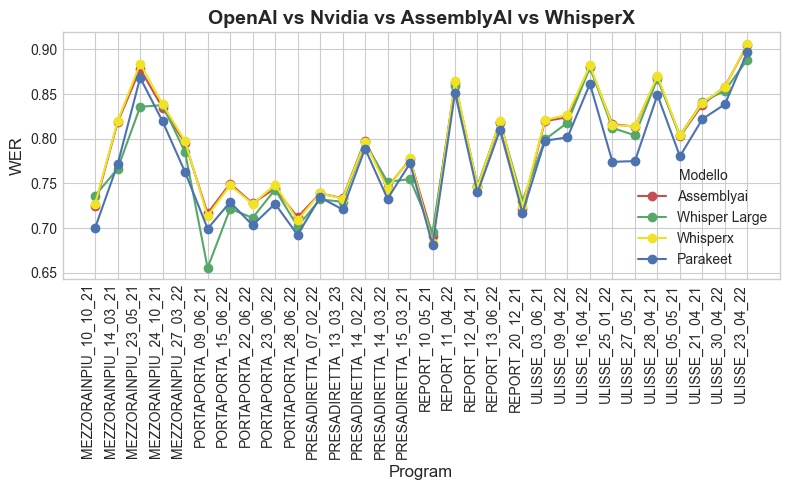

In [ ]:
import plot

plot.plot_single_episode(bleurt_results, models=["assemblyai","whisper_large","whisperx","parakeet"], metric_name="BLEURT")

### Per titolo di programma

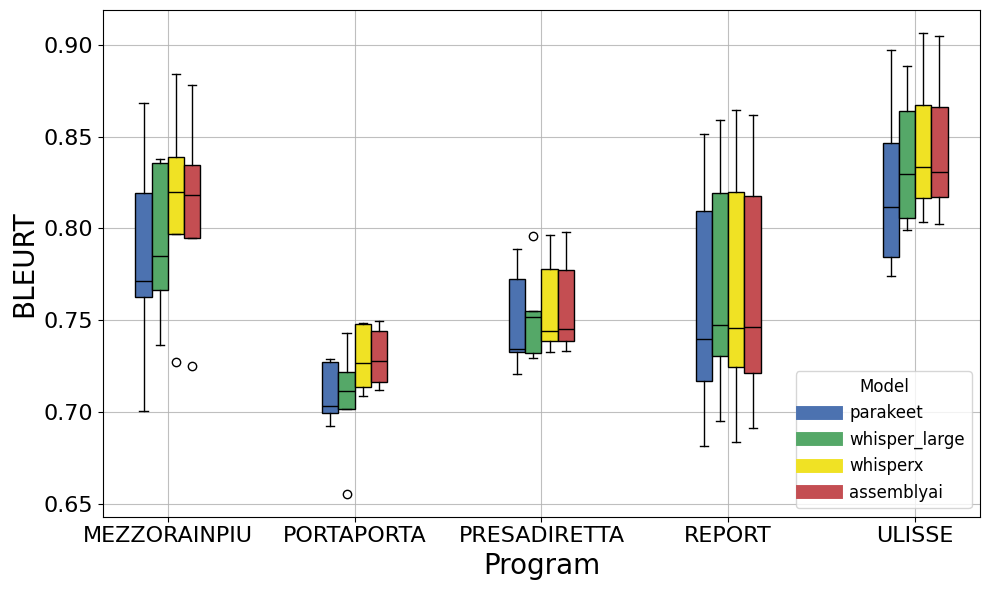

In [3]:
import plot

plot.plot_program(bleurt_results, "bleurt", models)

### Per tipologia

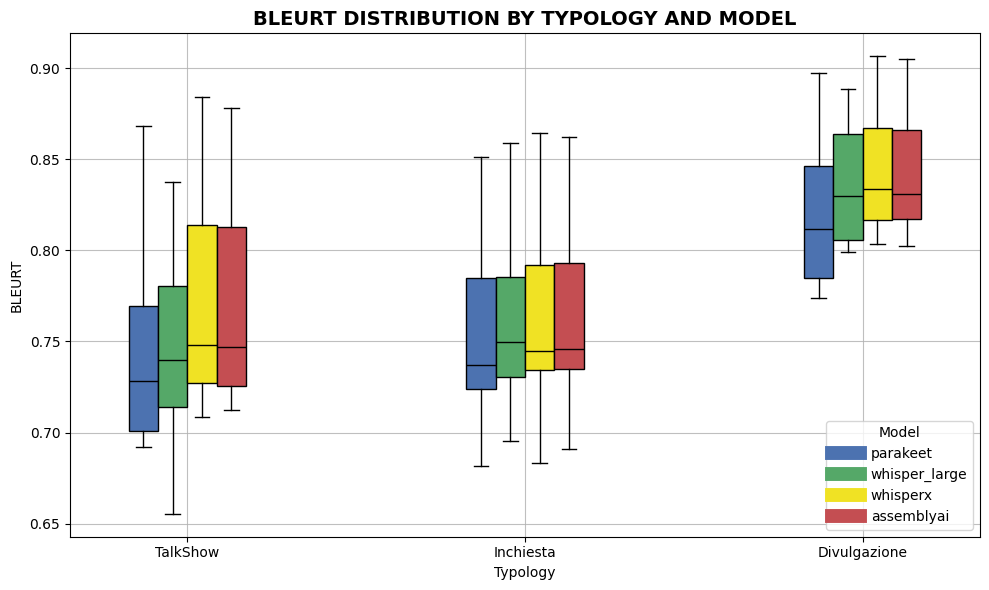

In [6]:
import plot

plot.plot_typology(bleurt_results, "bleurt", models)